In [2]:
%matplotlib inline

import logging, io, json, warnings
logging.basicConfig(level="INFO")
warnings.filterwarnings('ignore')

def pprint(o):
    # small helper to make dict dumps a bit prettier
    print(json.dumps(o, indent=2))
    


In [3]:
import sys
python = sys.executable

# In your environment run:
#!{python} -m pip install -U rasa_core rasa_nlu[spacy];

# as well as install a language model:
#!{python} -m spacy download de_core_web_md;
#!{python} -m spacy link --force de_core_web_md de;

In [4]:
#technische Umgebung starten

import rasa_nlu
import rasa_core
import spacy

print("rasa_nlu: {} rasa_core: {}".format(rasa_nlu.__version__, rasa_core.__version__))
print("Loading spaCy language model...")
print(spacy.load("de")("Spacy erfolgreich gestartet"))

rasa_nlu: 0.13.8 rasa_core: 0.13.0a1
Loading spaCy language model...
Spacy erfolgreich gestartet


In [5]:
#1. create story
stories_md = """
## greet user
* greet
  - utter_greet
  - utter_feeling
  - utter_introduction
  
* feelinggood
  - utter_happy

* registeruser
  - utter_registerstart
  - utter_firstname
  - utter_lastname
  - utter_jobtitle
  - utter_company
  - utter_skillset

## say goodbye
* goodbye
  - utter_goodbye
  
## fallback
- utter_unclear

"""
%store stories_md > stories.md
print("Stories gespeichert")

Writing 'stories_md' (str) to file 'stories.md'.
Stories gespeichert


In [6]:
#2. domain definieren
domain_yml = """
intents:
  - greet
  - goodbye
  - feelinggood
  - feelingbad
  - registeruser

entities:
- name
- company
- jobtitle


actions:
- utter_greet
- utter_cheer_up
- utter_did_that_help
- utter_feeling
- utter_happy
- utter_unhappy
- utter_goodbye
- utter_introduction
- utter_unclear
- utter_registerstart
- utter_firstname
- utter_lastname
- utter_jobtitle
- utter_company
- utter_skillset

templates:
  utter_greet:
  - text: "Hallo!"
  - text: "Wie heißt Du?"
  
  utter_feeling:
  - text: "Wie fühlst Du Dich heute?"

  utter_introduction:
  - text: "Ich bin Laura und leite Dich durch die Registrierung!"

  utter_registerstart:
  - text: "Bist Du bereit mit der Registrierung zu starten?"
 
  utter_firstname:
  - text: "Nenne mir bitte Deinen Vornamen."
  
  utter_lastname:
  - text: "Nenne mir bitte Deinen Nachnamen."
 
  utter_jobtitle:
  - text: "Was ist Deine aktuelle Jobbezeichnung?" 

  utter_company:
  - text: "Bei welcher Firma bist Du beschäftigt?" 

  utter_skillset:
  - text: "Nenne mir Deine wichtigste Fähigkeit." 

  utter_cheer_up:
  - text: "Hier ist etwas um Deine Laune anzuheben:"
    image: "https://i.imgur.com/nGF1K8f.jpg"

  utter_did_that_help:
  - text: "Geht's jetzt besser??"

  utter_happy:
  - text: "Läuft! Ich fühle mich auch super!"

  utter_feelingbad:
  - text: "Kopf hoch, wird schon besser werden"
  - text: "Ach komm, so schlimm kann es nicht sein"

  utter_goodbye:
  - text: "Bye Bye"
  
  utter_unclear:
  - text: "Ich verstehe leider nicht was Du meinst."
"""
%store domain_yml > domain.yml

print("Domainfile gespeichert!")

Writing 'domain_yml' (str) to file 'domain.yml'.
Domainfile gespeichert!


Schlüsselworter als intents erstellen

In [7]:
#intents
nlu_md = """
## intent:greet
- Hallo
- Hallo, bin [Peter](PERSON)
- Hi,  bin's [Dominik](PERSON)
- Hi, Name ist [Nico](PERSON)
- [Florian](PERSON) hier
- Hi
- Moin
- Moin Moin
- Servus
- Grützi
- Guten Tag
- Guten Mittag
- Prost
- Mahlzeit
- hi dude
- hey kollege


## intent:goodbye
- cu
- bye bye
- bis später
- schönen abend noch
- tschüss
- gute nacht
- adios
- schönen tag noch

## intent:feelinggood
- super
- spitze
- klasse
- bestens
- schon ok
- ganz gut
- ok wie es ist
- läuft
- perfekt
- 1a
- sehr gut

## intent:feelingbad
- schlecht
- schmerzen
- krank
- geht so
- beschissen
- mäßig 
- ungut
- nicht gut
- krank
- verärgert


## intent:registeruser
- registrieren
- anmelden
- benutzer anmelden
- regist
- start
- mitmachen

"""

%store nlu_md > nlu.md

print("Schlüsselwörter zu intents gespeichert!")

Writing 'nlu_md' (str) to file 'nlu.md'.
Schlüsselwörter zu intents gespeichert!


In [8]:
#config file erstellen
config = """
language: "de"

pipeline:
- name: "nlp_spacy"                   # loads the spacy language model
- name: "tokenizer_spacy"             # splits the sentence into tokens
- name: "ner_spacy"                   # uses the pretrained spacy NER model
- name: "intent_featurizer_spacy"     # transform the sentence into a vector representation
- name: "intent_classifier_sklearn"   # uses the vector representation to classify using SVM
""" 

%store config > config.yml

Writing 'config' (str) to file 'config.yml'.


### training the model

In [14]:
from rasa_nlu.training_data import load_data
from rasa_nlu.config import RasaNLUModelConfig
from rasa_nlu.model import Trainer
from rasa_nlu import config

# loading the nlu training samples
training_data = load_data("nlu.md")

# trainer to educate our pipeline
trainer = Trainer(config.load("config.yml"))

# train the model!
interpreter = trainer.train(training_data)

# store it for future use
model_directory = trainer.persist("./models/nlu", fixed_model_name="current")

INFO:rasa_nlu.training_data.loading:Training data format of nlu.md is md
INFO:rasa_nlu.training_data.training_data:Training data stats: 
	- intent examples: 51 (5 distinct intents)
	- Found intents: 'feelinggood', 'registeruser', 'feelingbad', 'goodbye', 'greet'
	- entity examples: 4 (1 distinct entities)
	- found entities: 'PERSON'

INFO:rasa_nlu.utils.spacy_utils:Trying to load spacy model with name 'de'
INFO:rasa_nlu.components:Added 'nlp_spacy' to component cache. Key 'nlp_spacy-de'.
INFO:rasa_nlu.model:Starting to train component nlp_spacy
INFO:rasa_nlu.model:Finished training component.
INFO:rasa_nlu.model:Starting to train component tokenizer_spacy
INFO:rasa_nlu.model:Finished training component.
INFO:rasa_nlu.model:Starting to train component ner_spacy
INFO:rasa_nlu.model:Finished training component.
INFO:rasa_nlu.model:Starting to train component intent_featurizer_spacy
INFO:rasa_nlu.model:Finished training component.
INFO:rasa_nlu.model:Starting to train component intent_clas

Fitting 2 folds for each of 6 candidates, totalling 12 fits


In [15]:
### evaluate the model
pprint(interpreter.parse("ich will mich anmelden"))

{
  "intent": {
    "name": "feelingbad",
    "confidence": 0.3321511862957351
  },
  "entities": [],
  "intent_ranking": [
    {
      "name": "feelingbad",
      "confidence": 0.3321511862957351
    },
    {
      "name": "greet",
      "confidence": 0.24544016326217444
    },
    {
      "name": "feelinggood",
      "confidence": 0.16383437484940347
    },
    {
      "name": "goodbye",
      "confidence": 0.14705250761413408
    },
    {
      "name": "registeruser",
      "confidence": 0.11152176797855334
    }
  ],
  "text": "ich will mich anmelden"
}


INFO:rasa_nlu.components:Added 'nlp_spacy' to component cache. Key 'nlp_spacy-de'.
INFO:rasa_nlu.training_data.loading:Training data format of nlu.md is md
INFO:rasa_nlu.training_data.training_data:Training data stats: 
	- intent examples: 51 (5 distinct intents)
	- Found intents: 'feelinggood', 'registeruser', 'feelingbad', 'goodbye', 'greet'
	- entity examples: 4 (1 distinct entities)
	- found entities: 'PERSON'

INFO:rasa_nlu.evaluate:Intent evaluation results:
INFO:rasa_nlu.evaluate:Intent Evaluation: Only considering those 51 examples that have a defined intent out of 51 examples
INFO:rasa_nlu.evaluate:F1-Score:  0.6842963572375337
INFO:rasa_nlu.evaluate:Precision: 0.66875735801567
INFO:rasa_nlu.evaluate:Accuracy:  0.7647058823529411
INFO:rasa_nlu.evaluate:Classification report: 
              precision    recall  f1-score   support

  feelingbad       0.83      1.00      0.91        10
 feelinggood       0.79      1.00      0.88        11
     goodbye       0.00      0.00      0.

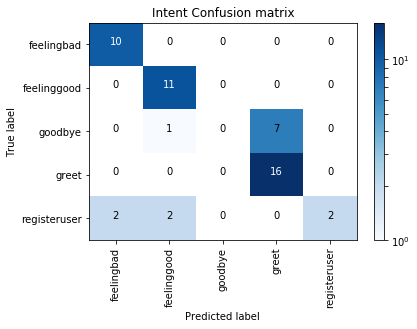

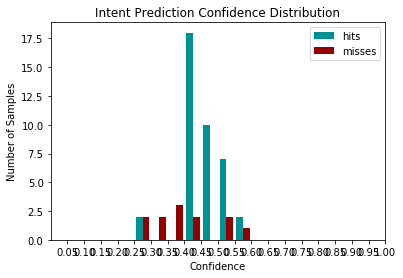

INFO:rasa_nlu.evaluate:Entity evaluation results:
INFO:rasa_nlu.evaluate:Evaluation for entity extractor: ner_spacy 
INFO:rasa_nlu.evaluate:F1-Score:  0.8708998831320608
INFO:rasa_nlu.evaluate:Precision: 0.939327731092437
INFO:rasa_nlu.evaluate:Accuracy:  0.8117647058823529
INFO:rasa_nlu.evaluate:Classification report: 
             precision    recall  f1-score   support

        LOC       0.00      0.00      0.00         0
       MISC       0.00      0.00      0.00         0
        PER       0.00      0.00      0.00         0
     PERSON       0.00      0.00      0.00         4
  no_entity       0.99      0.85      0.91        81

avg / total       0.94      0.81      0.87        85



In [11]:
#testdatensetz
from rasa_nlu.evaluate import run_evaluation

run_evaluation("nlu.md", model_directory)

train the model

In [16]:
from rasa_core.policies import FallbackPolicy, KerasPolicy, MemoizationPolicy
from rasa_core.agent import Agent

# this will catch predictions the model isn't very certain about
# there is a threshold for the NLU predictions as well as the action predictions
fallback = FallbackPolicy(fallback_action_name="utter_unclear",
                          core_threshold=0.2,
                          nlu_threshold=0.6)

agent = Agent('domain.yml', policies=[MemoizationPolicy(), KerasPolicy(), fallback])

# loading our neatly defined training dialogues
training_data = agent.load_data('stories.md')

agent.train(
    training_data,
    validation_split=0.0,
    epochs=200
)

agent.persist('models/dialogue')

/Users/patrick/anaconda3/lib/python3.6/site-packages/pykwalify/core.py:99: UnsafeLoaderWarning: 
The default 'Loader' for 'load(stream)' without further arguments can be unsafe.
Use 'load(stream, Loader=ruamel.yaml.Loader)' explicitly if that is OK.
Alternatively include the following in your code:

  import warnings
  warnings.simplefilter('ignore', ruamel.yaml.error.UnsafeLoaderWarning)

In most other cases you should consider using 'safe_load(stream)'
  data = yaml.load(stream)
Processed Story Blocks: 100%|██████████| 3/3 [00:00<00:00, 153.65it/s, # trackers=13]
Processed actions: 97it [00:00, 322.04it/s, # examples=97]
INFO:rasa_core.policies.keras_policy:Fitting model with 97 total samples and a validation split of 0.1


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking (Masking)            (None, 5, 27)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                7680      
_________________________________________________________________
dense (Dense)                (None, 19)                627       
_________________________________________________________________
activation (Activation)      (None, 19)                0         
Total params: 8,307
Trainable params: 8,307
Non-trainable params: 0
_________________________________________________________________


TypeError: fit() got multiple values for keyword argument 'epochs'

In [ ]:
from rasa_core.agent import Agent
agent = Agent.load('models/dialogue', interpreter=model_directory)

In [ ]:
## testnachrichten
print("Your bot is ready to talk! Type your messages here or send 'stop'")
while True:
    a = input()
    if a == 'stop':
        break
    responses = agent.handle_message(a)
    for response in responses:
        print(response["text"])